In [2]:
!git clone https://github.com/zae-bayern/elpv-dataset

Cloning into 'elpv-dataset'...
remote: Enumerating objects: 2695, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 2695 (delta 2), reused 7 (delta 1), pack-reused 2686
Receiving objects: 100% (2695/2695), 90.79 MiB | 28.58 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [3]:
# to see everything that has been downloaded
!ls elpv-dataset/
# no. of images in the dataset
!ls elpv-dataset/images | wc -l
# code in the dataset repo
!ls elpv-dataset/utils

doc  images  labels.csv  LICENSE.md  README.md	utils
2624
elpv_reader.py


In [4]:
# access code 
import sys
sys.path.append('elpv-dataset/utils')

In [5]:
# dataset README file said to do this to load the dataset into memory in python
from elpv_reader import load_dataset
elpv_images, elpv_proba, elpv_types = load_dataset()

In [6]:
# dataset matrix ??
elpv_images.shape

(2624, 300, 300)

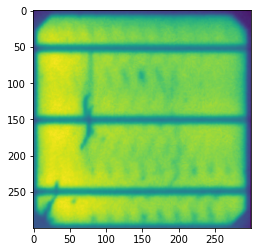

In [7]:
# what is data 
import matplotlib.pyplot as plt
plt.imshow(elpv_images [0])

In [8]:
# labels ?
elpv_proba.shape

(2624,)

In [9]:
# label values
set(elpv_proba)

{0.0, 0.3333333333333333, 0.6666666666666666, 1.0}

In [10]:
set(elpv_types)

{'mono', 'poly'}

In [11]:
# pytorch libraries
import torch
import torchvision
import torchvision.transforms as transforms

In [12]:
# pytorch needs to know how to open up images + read labels

import cv2

class PlainDataset(torch.utils.data.Dataset):
  def __init__(self, img_array_list, transform, label_list):
    self.transform = transform 
    self.img_array_list = img_array_list
    self.label_list = label_list

  def __len__(self):
    return len(self.img_array_list)

  def __getitem__(self, idx):
    gray = self.img_array_list[idx]
    gray = cv2.resize(gray, dsize = (40,40), interpolation = cv2. INTER_CUBIC)
    gray = gray[4:36, 4:36] # 64 px square
    image = cv2.merge((gray, gray, gray))
    image = self.transform(image)

    label = self.label_list[idx]

    return image, label

In [13]:
import numpy as np

# normalizing images before loading into cnn
transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# images to be in update step
batch_size = 4

# split dataset into test and train (2000/624), randomly sampled
shuffle_idx = [ind for ind in range(len(elpv_images))]
np.random.shuffle(shuffle_idx)

# instead of computing a continuous probability of whether a solar cell si defective - network will classify image as 0 (which is good), or 1, 2, 3 with 3 being most defective
trainset = PlainDataset(img_array_list=[elpv_images[j] for j in shuffle_idx[:2000]], 
                        transform=transform, 
                        label_list=[int(elpv_proba[j]*3) for j in shuffle_idx[:2000]])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = PlainDataset(img_array_list=[elpv_images[j] for j in shuffle_idx[2000:]], 
                        transform=transform, 
                        label_list=[int(elpv_proba[j]*3) for j in shuffle_idx[2000:]])
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [14]:
len(trainset)
len(testset)

624

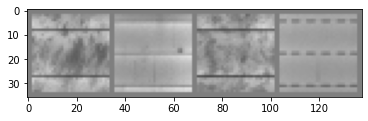

0 3 0 1


In [15]:
# make sure dataloaders are loading images + labels properly
def imshow(img):
  img = img / 2 +0.5 # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()


# random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{labels[j]}' for j in range(batch_size)))

In [1]:
# define model - 2 convolutional layers with 18 5x5 kernels in the first layer, 96 5x5 kernels
# 3 linear layers with decreasing numbers of parameters in each - total of 61,266 parameters to learn

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, num_classes: int = 1000):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        # makes output "image" of the first layer smaller = less compute time
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

        # new network initialized with 0 - not optima;
        nn.init.kaiming_normal_(self.conv1.weight.data,nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2.weight.data,nonlinearity='relu')

    # tell training functions how to calculate output using the neural network - pytorch library automates calculating the derivative from the loss
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [17]:
import torch.optim as optim

# declaring a new network

net = Net (num_classes = 4)

# show how loss needs to be calculated
criterion = nn.CrossEntropyLoss()

# learning rate - aka how big of a step we take with each new guess
lr = 1e-3
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

# try to find a good lr by randomly trying a few
best_loss = 100
best_lr = lr
best_net = net
tries = 0

while tries < 20:
  for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()
      if i%100==99:
        if running_loss < best_loss:
          best_net = net
          best_lr = lr
          best_loss = running_loss
          print(f"New best loss with lr {best_lr}")

        print(f'[{epoch+1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
        running_loss = 0.0

  net = Net(num_classes=4)
  lr = np.random.default_rng().uniform(low=1e-5, high=1e-3)
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

  tries += 1
  print(f'*********************** lr = {lr}')

print('Finished Training')

[1,   100] loss: 1.209
[1,   200] loss: 1.026
[1,   300] loss: 1.014
New best loss with lr 0.001
[1,   400] loss: 0.963
[1,   500] loss: 1.032
New best loss with lr 0.001
[2,   100] loss: 0.890
[2,   200] loss: 0.935
[2,   300] loss: 0.929
[2,   400] loss: 0.955
[2,   500] loss: 0.959
*********************** lr = 0.00035700268829668883
[1,   100] loss: 1.257
[1,   200] loss: 1.071
[1,   300] loss: 1.028
[1,   400] loss: 1.068
[1,   500] loss: 1.051
[2,   100] loss: 1.025
[2,   200] loss: 1.019
[2,   300] loss: 1.051
[2,   400] loss: 0.977
[2,   500] loss: 0.959
*********************** lr = 0.0005083043576180878
[1,   100] loss: 1.301
[1,   200] loss: 1.187
[1,   300] loss: 1.025
[1,   400] loss: 0.985
[1,   500] loss: 1.025
[2,   100] loss: 1.044
[2,   200] loss: 1.006
[2,   300] loss: 0.961
[2,   400] loss: 0.998
[2,   500] loss: 0.985
*********************** lr = 0.0006791250383963102
[1,   100] loss: 1.190
[1,   200] loss: 1.001
[1,   300] loss: 1.045
[1,   400] loss: 1.027
[1,   50

In [18]:
# helper function to see how network is improving over the course of training

from IPython.display import clear_output
from matplotlib import pyplot as plt

def loss_plot(train_batches, train_loss, test_batches, test_loss,
              figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)

    if len(train_batches) <= 1 or len(test_batches) <= 1:
      return

    plt.scatter(train_batches, train_loss, label='train', color='k') 
    m, b = np.polyfit(train_batches, train_loss, 1)
    plt.plot(train_batches, [train_batches * m for train_batches in train_batches] + b)

    plt.scatter(test_batches, test_loss, label='test', color='y') 
    m, b = np.polyfit(test_batches, test_loss, 1)
    plt.plot(test_batches, [test_batches * m for test_batches in test_batches] + b)

    plt.title(title)
    plt.grid(True)
    plt.xlabel('mini batches')
    plt.ylabel('loss')
    plt.show();

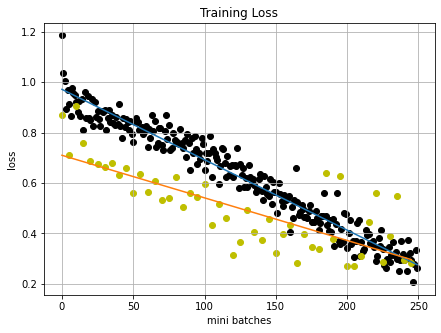

Network began overfitting at epoch 37


In [19]:
# finally training yay
# need to figure out when the network is starting to overfit to training set - so will print the loss on the test set

net = Net(num_classes=4)
optimizer = optim.SGD(net.parameters(), lr=best_lr, momentum=0.9)

import copy

# PyTorch network are pointers so you need to copy the values if you dont want the new variables to be updated
not_overfit_net = copy.deepcopy(net)
early_net = copy.deepcopy(net)
overfit_epoch = -1

loss_trend = []
test_loss_trend = []
for epoch in range(50): # loop over the dataset multiple times

  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    # get inputs; data is a list of [inputs, labels]
    inputs, labels = data

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()

    if i % 100 == 99: # print every 100 mini-batches
      loss_trend.append(running_loss / 100)
      running_loss = 0.0

      loss_plot(range(len(loss_trend)), loss_trend, [x*5 for x in range(len(test_loss_trend))], test_loss_trend, title = "training loss")
  
  with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        test_loss = criterion(outputs, labels)
    test_loss_trend.append(test_loss)
  loss_plot(range(len(loss_trend)), loss_trend, [x*5 for x in range(len(test_loss_trend))], test_loss_trend, title='Training Loss')

  # if overfitting -> save the last state of the network before it does
  if test_loss_trend[-1] <= loss_trend[-1] and overfit_epoch == -1:
    not_overfit_net = copy.deepcopy(net)
  if epoch == 20:
    early_net = copy.deepcopy(net)
  
  # if test loss is worse than the training loss -> overfitting
  if test_loss_trend[-1] > loss_trend[-1] and overfit_epoch==-1:
    overfit_epoch = epoch
  
print(f'Network began overfitting at epoch {overfit_epoch}')


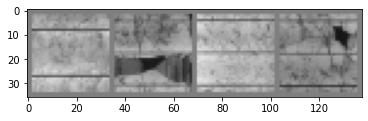

ground truth:  0303


In [21]:
# check - what network classifies on the test set
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print ('ground truth: ', ''.join(f'{labels[j]}'for j in range(4)))

In [23]:
# how well was this done
correct = 0
total = 0
# since there's no training, theres no need to calculate the gradients for outputs
with torch.no_grad():
  for data in trainloader:
    images, labels = data
    # calculate outputs by running images through network
    outputs = net(images)
    # class with highest energy is what is chosen as prediction
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted ==labels).sum().item()

print(f'accuracy on the {len(trainset)} train images: {100 * correct // total} %')

accuracy on the 2000 train images: 92 %


In [24]:
# before overfitting began - how good was it classifying images

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = not_overfit_net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'accuracy of not-overfit on the {len(trainset)} train images: {100 * correct // total} %')

accuracy of not-overfit on the 2000 train images: 86 %


In [28]:
# how well did it learn to classify test images

correct = 0
total = 0
# since we're not training = no calculation for gradients for outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy = prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'accuracy on the {len(testset)} test images: {100 * correct // total} %')

accuracy on the 624 test images: 65 %


In [29]:
# how well does the not-overfit network classify test images

correct = 0
total = 0
# since we're not training = no calculation for gradients for outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = not_overfit_net(images)
        # the class with the highest energy = prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'accuracy of not-overfit on the {len(testset)} test images: {100 * correct // total} %')

accuracy of not-overfit on the 624 test images: 65 %


In [31]:
# where network is failing

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in range(4)}
total_pred = {classname: 0 for classname in range(4)}

# no gradients needed because no training 
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[int(f'{label}')] += 1
            total_pred[int(f'{label}')] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    chance = 100 * float(total_pred[classname]) / sum(total_pred.values())
    print(f'Accuracy for class: {classname} is {accuracy:.1f} % (chance is {chance:.1f} %)')

Accuracy for class: 0 is 79.5 % (chance is 56.4 %)
Accuracy for class: 1 is 22.1 % (chance is 12.3 %)
Accuracy for class: 2 is 3.6 % (chance is 4.5 %)
Accuracy for class: 3 is 65.9 % (chance is 26.8 %)


In [32]:
# to count predictions for each class
correct_pred = {classname: 0 for classname in range(4)}
total_pred = {classname: 0 for classname in range(4)}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = not_overfit_net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[int(f'{label}')] += 1
            total_pred[int(f'{label}')] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    chance = 100 * float(total_pred[classname]) / sum(total_pred.values())
    print(f'Accuracy for (not-overfit) class: {classname} is {accuracy:.1f} % (chance is {chance:.1f} %)')

Accuracy for (not-overfit) class: 0 is 81.8 % (chance is 56.4 %)
Accuracy for (not-overfit) class: 1 is 31.2 % (chance is 12.3 %)
Accuracy for (not-overfit) class: 2 is 0.0 % (chance is 4.5 %)
Accuracy for (not-overfit) class: 3 is 57.5 % (chance is 26.8 %)


In [33]:
# code from staford course cs231n
from math import sqrt, ceil
import numpy as np

def visualize_grid(Xs, ubound=255.0, padding=1):
  """
  Reshape a 4D tensor of image data to a grid for easy visualization.
  Inputs:
  - Xs: Data of shape (N, H, W, C)
  - ubound: Output grid will have values scaled to the range [0, ubound]
  - padding: The number of blank pixels between elements of the grid
  """
  (N, H, W, C) = Xs.shape
  grid_size = int(ceil(sqrt(N)))
  grid_height = H * grid_size + padding * (grid_size - 1)
  grid_width = W * grid_size + padding * (grid_size - 1)
  grid = np.zeros((grid_height, grid_width, C))
  next_idx = 0
  y0, y1 = 0, H
  for y in range(grid_size):
    x0, x1 = 0, W
    for x in range(grid_size):
      if next_idx < N:
        img = Xs[next_idx]
        low, high = np.min(img), np.max(img)
        grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)

        next_idx += 1
      x0 += W + padding
      x1 += W + padding
    y0 += H + padding
    y1 += H + padding

  return grid

def vis_grid(Xs):
  """ visualize a grid of images """
  (N, H, W, C) = Xs.shape
  A = int(ceil(sqrt(N)))
  G = np.ones((A*H+A, A*W+A, C), Xs.dtype)
  G *= np.min(Xs)
  n = 0
  for y in range(A):
    for x in range(A):
      if n < N:
        G[y*H+y:(y+1)*H+y, x*W+x:(x+1)*W+x, :] = Xs[n,:,:,:]
        n += 1
  # normalize to [0,1]
  maxg = G.max()
  ming = G.min()
  G = (G - ming)/(maxg-ming)
  return G
  
def vis_nn(rows):
  """ visualize array of arrays of images """
  N = len(rows)
  D = len(rows[0])
  H,W,C = rows[0][0].shape
  Xs = rows[0][0]
  G = np.ones((N*H+N, D*W+D, C), Xs.dtype)
  for y in range(N):
    for x in range(D):
      G[y*H+y:(y+1)*H+y, x*W+x:(x+1)*W+x, :] = rows[y][x]
  # normalize to [0,1]
  maxg = G.max()
  ming = G.min()
  G = (G - ming)/(maxg-ming)
  return G

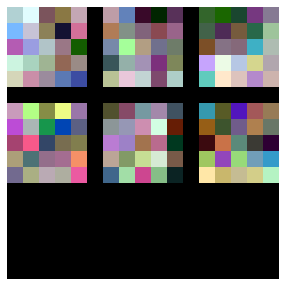

In [34]:
# learned kernels visualization
grid = visualize_grid(net.conv1.weight.detach().numpy().transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()